# Обучение наивного детектора лица EfficientDet D0
## TensorFlow 2 Object Detection API

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import cv2
import urllib.request as urllib

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

import zipfile

%matplotlib inline

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
#run model builder test
#!python /tensorflow/models/research/object_detection/builders/model_builder_tf2_test.py

In [ ]:
# Определим некоторые вспомогательные функции
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

def image_url_to_numpy_array_urllib(url,format=None):
    ## read as HTTPResponse 
    resp = urllib.urlopen(url)
    ## read as 1D bytearray
    resp_byte_array = resp.read()
    ## returns a bytearray object which is a mutable sequence of integers in the range 0 <=x< 256
    mutable_byte_array = bytearray(resp_byte_array)
    ## read as unsigned integer 1D numpy array
    image = np.asarray(mutable_byte_array, dtype="uint8")
    ## To decode the 1D image array into a 2D format with RGB color components we make a call to cv2.imdecode
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if format=='BGR' :
        ## return BGR format array
        return image
    ## cv2.imdecode converted array into BGR format , convert it to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # return the image
    return image

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# Скачаем заранее подготовленный мною в tfrecord датасет Wider Faces
!mkdir -p /app/data
file_id = '1EHj4JMNrGt6GcurOmA-e0YGNBCwfKBCj'
destination = '/app/data/wider_dataset.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)
    zip_ref = zipfile.ZipFile(destination, 'r')
    zip_ref.extractall("/app/data")
    zip_ref.close()

In [7]:
"""
The tf2 version is based in https://github.com/jschw/tfrecord-view/blob/master/tfrecord_view_gui.py
view_records.py:
Consume and display data from a tfrecord file: pulls image and bounding boxes for display
so you can make sure things look reasonabloe, e.g., after augmentation.
Hit 'n' for 'next' image, or 'esc' to quit.
Part of tensorflow-view repo: https://github.com/EricThomson/tfrecord-view
"""

import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)  #tf 1.14 and np 1.17 are clashing: temporary solution

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def cv_bbox(image, bbox, color = (255, 255, 255), line_width = 2):
    """
    use opencv to add bbox to an image
    assumes bbox is in standard form x1 y1 x2 y2
    """

    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, line_width)
    return


def parse_record(data_record):
    """
    parse the data record from a tfrecord file, typically pulled from an iterator,
    in this case a one_shot_iterator created from the dataset.
    """
    feature = {'image/encoded': tf.io.FixedLenFeature([], tf.string),
                'image/object/class/label': tf.io.VarLenFeature(tf.int64),
                'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
                'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
                'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
                'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
                'image/filename': tf.io.FixedLenFeature([], tf.string)
                }
    return tf.io.parse_single_example(data_record, feature)


def view_records(file_path, class_labels, stride = 1, verbose=1, show_imgs=10):
    """
    peek at the data using opencv and tensorflow tools.
    Inputs:
        file_path: path to tfrecord file (usually has 'record' extension)
        class_labels: dictionary of labels with name:number pairs (start with 1)
        stride (default 1): how many records to jump (you might have thousands so skip a few)
        verbose (default 1): display text output if 1, display nothing except images otherwise.
    Usage:
    Within the image window, enter 'n' for next image, 'esc' to stop seeing images.
    """
    
    image_list = []
    
    with tf.device('/cpu:0'):
        dataset = tf.data.TFRecordDataset([file_path])
        record_iterator = iter(dataset)
        #num_records = dataset.reduce(np.int64(0), lambda x, _: x + 1).numpy()

        for im_ind in range(show_imgs):

            #Parse and process example

            parsed_example = parse_record(record_iterator.get_next())
            if im_ind % stride != 0:
                continue

            fname = parsed_example['image/filename'].numpy()
            encoded_image = parsed_example['image/encoded']
            image_np = tf.image.decode_image(encoded_image, channels=3).numpy()

            labels =  tf.sparse.to_dense(parsed_example['image/object/class/label'], default_value=0).numpy()
            x1norm =  tf.sparse.to_dense( parsed_example['image/object/bbox/xmin'], default_value=0).numpy()
            x2norm =  tf.sparse.to_dense( parsed_example['image/object/bbox/xmax'], default_value=0).numpy()
            y1norm =  tf.sparse.to_dense( parsed_example['image/object/bbox/ymin'], default_value=0).numpy()
            y2norm =  tf.sparse.to_dense( parsed_example['image/object/bbox/ymax'], default_value=0).numpy()

            num_bboxes = len(labels)

            #% Process and display image
            height, width = image_np[:, :, 1].shape
            image_rgb = image_np.copy()

            if num_bboxes > 0:
                x1 = np.int64(x1norm*width)
                x2 = np.int64(x2norm*width)
                y1 = np.int64(y1norm*height)
                y2 = np.int64(y2norm*height)
                for bbox_ind in range(num_bboxes):
                        bbox = (x1[bbox_ind], y1[bbox_ind], x2[bbox_ind], y2[bbox_ind])
                        label_name = list(class_labels.keys())[list(class_labels.values()).index(labels[bbox_ind])]
                        label_position = (bbox[0] + 5, bbox[1] + 20)
                        cv_bbox(image_rgb, bbox, color = (250, 250, 150), line_width = 2)
                        cv2.putText(image_rgb,
                                    label_name,
                                    label_position,
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    1, (10, 10, 255), 2); #scale, color, thickness

            image_list.append(image_rgb)
        
    show_images(image_list, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


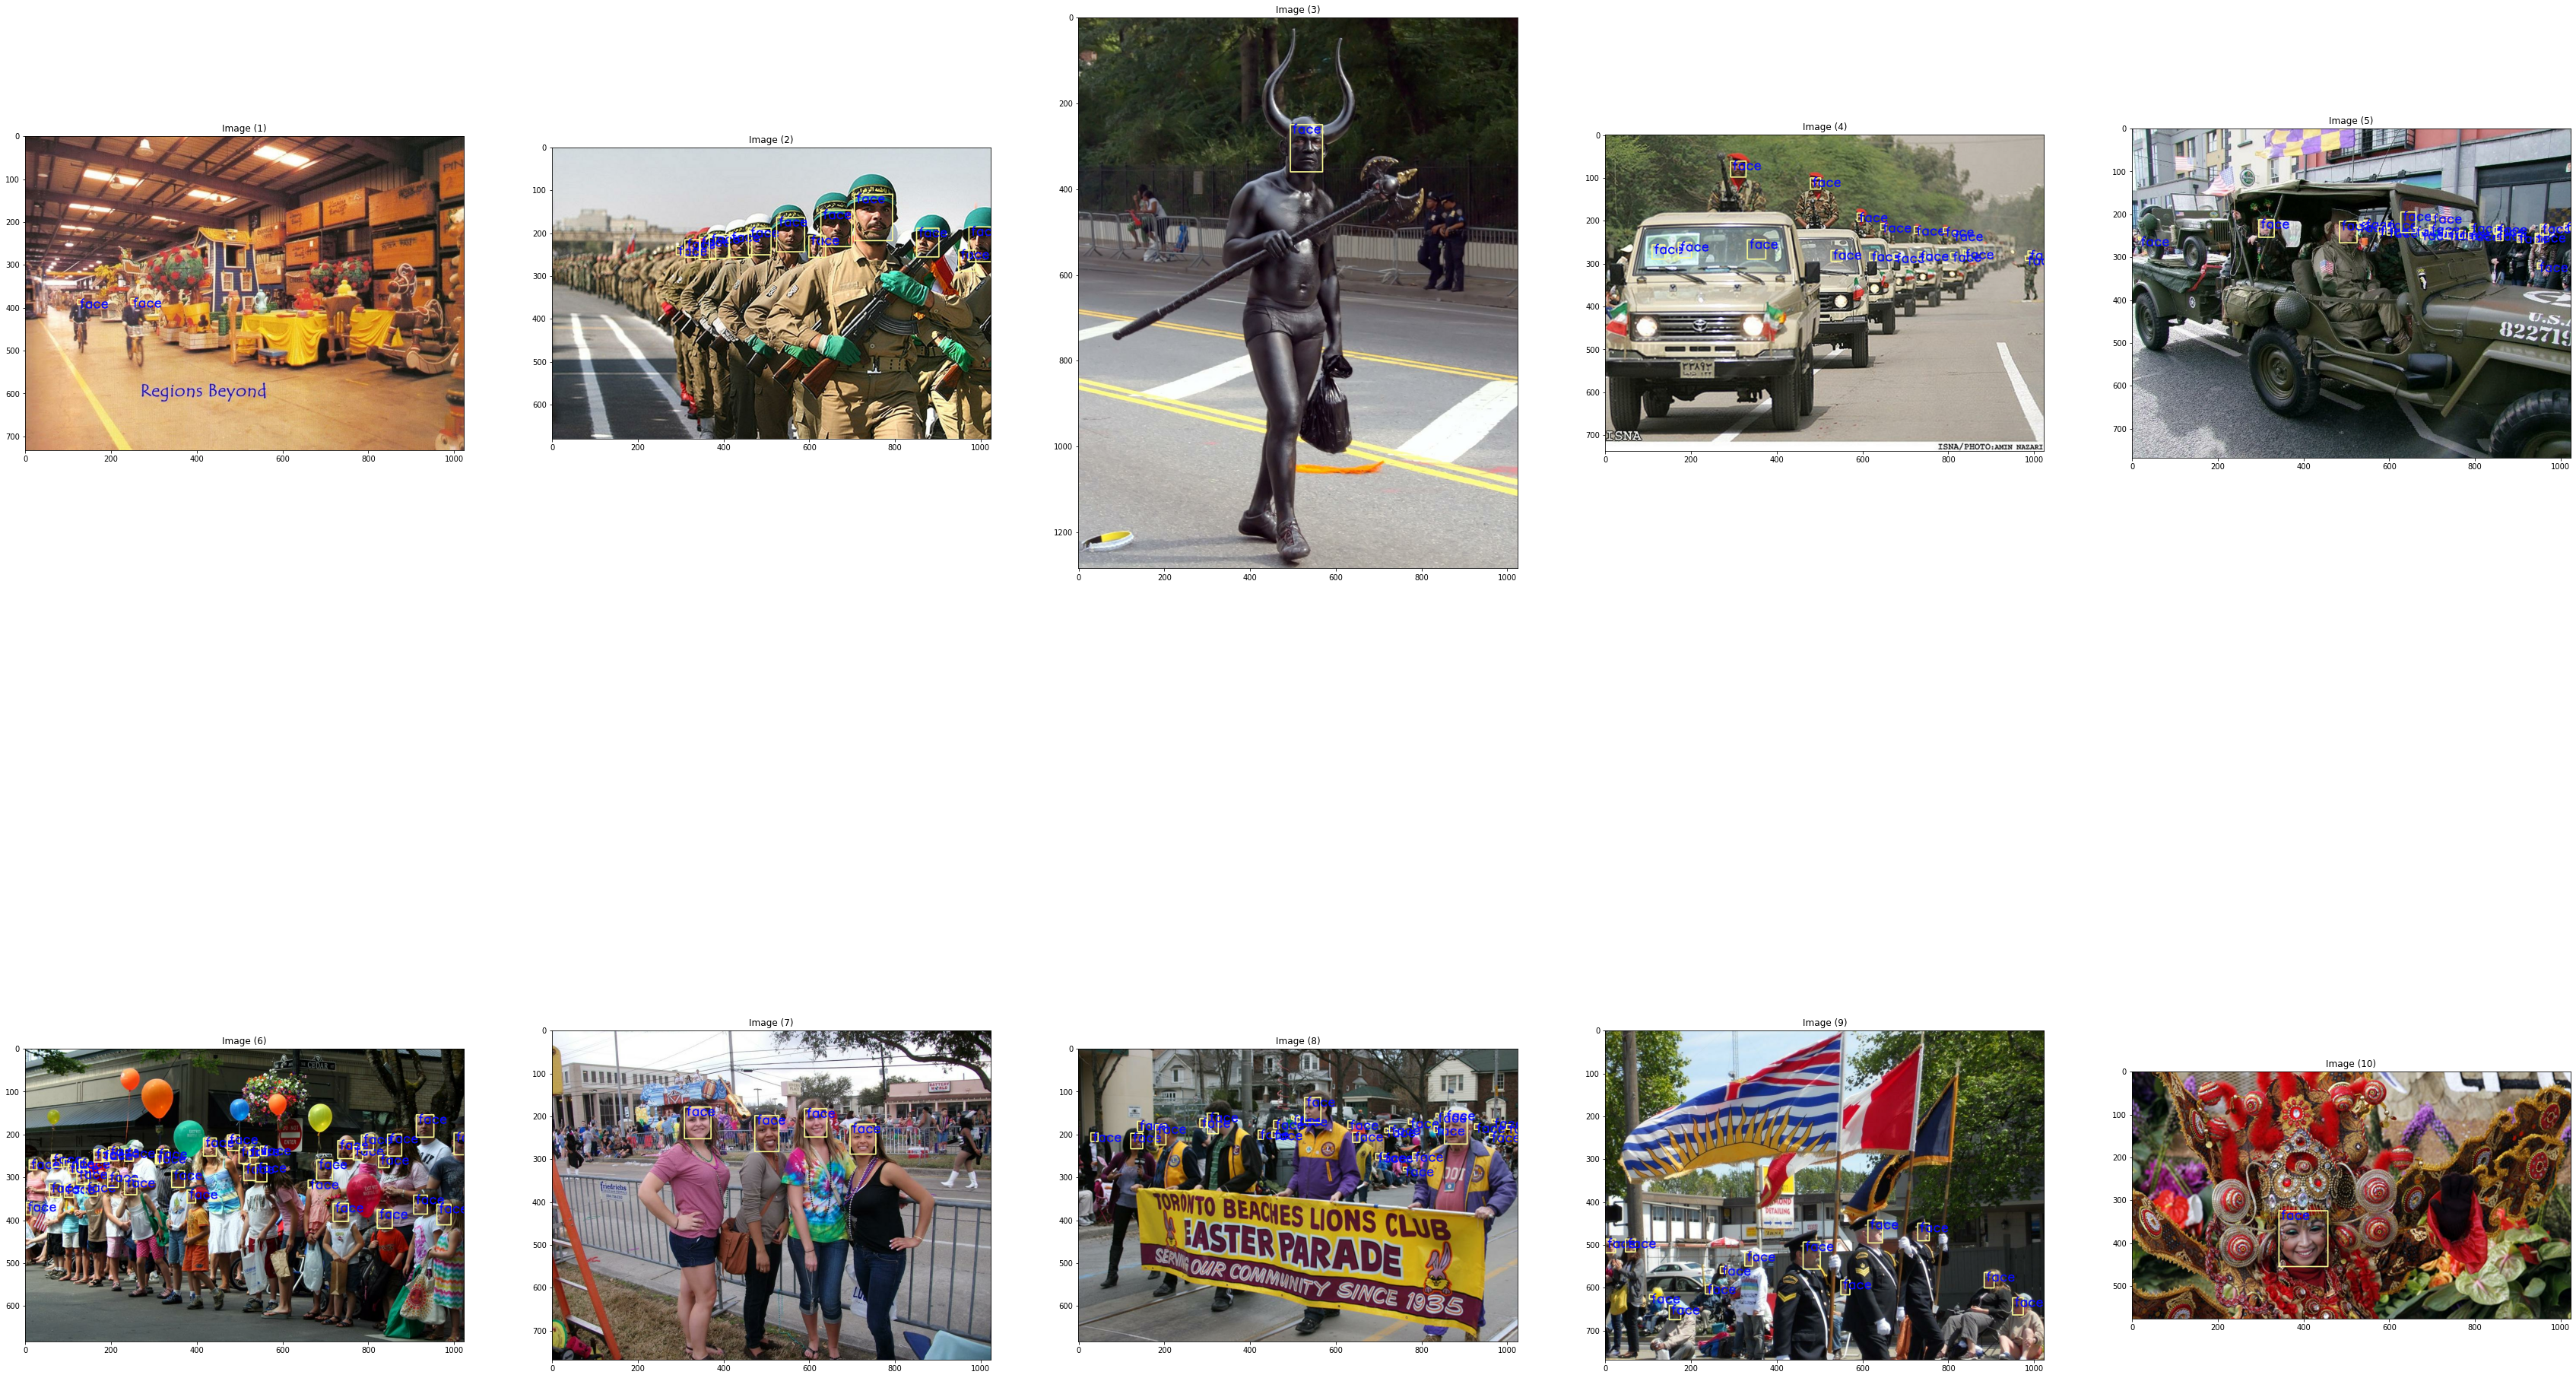

In [8]:
# Посмотрим на наши сэмплы
class_labels =  {"face" : 1}
data_path = "/app/data/train.record"

verbose = 1
stride = 1

view_records(data_path, class_labels, stride = stride, verbose = verbose)

In [9]:
# Наши данные для обучения
test_record_fname = '/app/data/val.record'
train_record_fname = '/app/data/train.record'
label_map_pbtxt_fname = '/app/data/label_map.pbtxt'

# Проверим наши метки
!cat /app/data/label_map.pbtxt

item {
  id: 1
  name: 'face'
}

In [10]:
BATCH_SIZE = 6
## Настройки для загрузки моделей из репозитория Object Detection Model Zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': BATCH_SIZE,
        'aspect_ratios': '[1.0, 1.3, 1.6]'
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': BATCH_SIZE,
        'aspect_ratios': '[1.0, 1.3, 1.6]'
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': BATCH_SIZE,
        'aspect_ratios': '[1.0, 1.3, 1.6]'
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': BATCH_SIZE,
        'aspect_ratios': '[1.0, 1.3, 1.6]'
    }
}

# Обучим самую простую модель, т.к. не обладаем крутой видеокартой
chosen_model = 'efficientdet-d0'

num_steps = 100000 # Количество шагов обучения 
num_eval_steps = 500 # Сколько шагов валидировать данные

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] # в нашем случае более 6 видеокарта выдаёт OOM

# Соотношение сторон якорных боксов. Я прогнал gt боксы через k-means и выбрал самые частые кластера.
anchor_aspect_ration = MODELS_CONFIG[chosen_model]['aspect_ratios'] 

In [ ]:
# Загрузим претрененные веса
%mkdir -p /app/models/research/deploy/
%cd /app/models/research/deploy/

import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

In [ ]:
# Загрузим базовый пайплайн конфиг
%cd /app/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

In [11]:
# Подготовим нашу конфигурацию обучения
pipeline_fname = '/app/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/app/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)

print(num_classes)

1


In [12]:
# Внесем в конфиг некоторые изменения

import re

%cd /app/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # Aspect Ratios
    s = re.sub(
        'aspect_ratios: \[1\.0, 2\.0, 0\.5\]', f'aspect_ratios: {anchor_aspect_ration}', s)
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord train / test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)  
    
    # fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
            
    f.write(s)

/app/models/research/deploy
writing custom configuration file


In [13]:
# Посмотрим на итоговую конфигурацию
%cat /app/models/research/deploy/pipeline_file.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      m

In [14]:
pipeline_file = '/app/models/research/deploy/pipeline_file.config'
model_dir = '/app/training/'

In [ ]:
# Проверим нашу видеокарту
!nvidia-smi

In [ ]:
# Обучаем наш детектор
!python /tensorflow/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

Подведем итоги обучения нашего детектора. За основу мы взяли детектор на основе sota классификатора EfficientNet --> EfficientDet D0 и попробовали натренировать его на задачю обнаружения лиц. Процесс обучения занял 21 час на 100000 шагов при этом средний loss на валидации достиг <b>0.48</b>. 

По графикам видно, что можно и дальше обучать этот детектор, но в боевую разработку мы возьмем другую модель, которая заточена под задачу детекции лиц - <b>RetinaFace</b>


In [ ]:
# Запустим модель на валидацию и посмотрим на метрики
!python /tensorflow/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}

 Как видим, точность нашего детектора при батче 6 и 100000 шагах оставляет желать лучшего. Будем считать данный детектор нашей наивной моделью :)
 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.451
 
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.207
 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.448
 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.651
 
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.203
 
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.146
 
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.527
 
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.705

In [ ]:
training_chart = '/app/efficientdet_d0.png'
traing_chart_img = plt.imread(training_chart)

plt.figure(figsize=(20,10))
plt.imshow(traing_chart_img)

In [ ]:
# Сконвертируем модель для будущего инференса
import re
import numpy as np

output_directory = '/app/fine_tuned_model'

# Укажем модель для экспорта
last_model_path = '/app/training/'
print(last_model_path)
!python /tensorflow/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

In [ ]:
# Проверим модель на тестовых данных
# Скачаем тестовые данные Wider Face
file_id = '1giyZMk6Z7yZBPTIttj66aJeWdUvrE8cS'
destination = '/app/data/wider_test.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)
    zip_ref = zipfile.ZipFile(destination, 'r')
    zip_ref.extractall("/app/data")
    zip_ref.close()

In [15]:
# Загрузим нашу модель
import pathlib

filenames = list(pathlib.Path('/app/training/').glob('*.index'))

filenames.sort()
print(filenames)

# Наш пайплайн обучения
pipeline_config = pipeline_file

# Загрузим последний чекпойнт обучения модели
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Восстановим его
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/app/training/ckpt-100.index'), PosixPath('/app/training/ckpt-101.index'), PosixPath('/app/training/ckpt-95.index'), PosixPath('/app/training/ckpt-96.index'), PosixPath('/app/training/ckpt-97.index'), PosixPath('/app/training/ckpt-98.index'), PosixPath('/app/training/ckpt-99.index')]


In [16]:
# Преобразуем метки для декодинга на инференсе
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [ ]:
# Проверим наш детектор на тестовых изображениях
import random

# Тестовая картинка из интернета
image_url = 'https://raw.githubusercontent.com/peteryuX/retinaface-tf2/master/data/0_Parade_marchingband_1_149.jpg'

TEST_IMAGE_PATHS = glob.glob('/app/data/test/test/images/**/*.jpg', recursive=True)
image_path = random.choice(TEST_IMAGE_PATHS)

#image_np = load_image_into_numpy_array(image_path)
image_np = image_url_to_numpy_array_urllib(image_url)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## Спасибо за внимание!